In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
import xlrd
import warnings
warnings.filterwarnings("ignore")

In [231]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [232]:
df = pd.read_csv('../data/all_data/cleaned_recent_data.csv')

In [233]:
df

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,BMI
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,24.691358
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,20.761246
2,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,23.959094
3,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",NaN,23.959094
4,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,Speed Skating Women's 500 metres,NaN,23.959094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196079,135569,Andrzej ya,M,29.0,179.0,89.0,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NaN,27.776911
196080,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NaN,19.047004
196081,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NaN,19.047004
196082,135571,Tomasz Ireneusz ya,M,30.0,185.0,96.0,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NaN,28.049671


In [234]:
df['Medal'] = df['Medal'].fillna('none')

In [235]:
# df = df[df['Season'] == 'Summer']

In [236]:
df['Sport'].nunique()

51

In [237]:
df['Event'].nunique()

489

In [238]:
feat = df.drop(columns=['Name', 'Games', 'Season', 'City', 'Team', 'Event', 'Sport'])

In [239]:
feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196084 entries, 0 to 196083
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      196084 non-null  int64  
 1   Sex     196084 non-null  object 
 2   Age     196084 non-null  float64
 3   Height  196084 non-null  float64
 4   Weight  196084 non-null  float64
 5   NOC     196084 non-null  object 
 6   Year    196084 non-null  int64  
 7   Medal   196084 non-null  object 
 8   BMI     196084 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 13.5+ MB


In [240]:
host_countries = pd.read_csv('../data/all_data/host_country.csv')
host_countries_recent = host_countries[host_countries['Year'] >= 1960].reset_index(drop=True)

noc_regions = pd.read_csv('../data/all_data/noc_regions.csv')

In [241]:
noc_regions = noc_regions.drop_duplicates(subset=['region'])

In [242]:
# Merge host countries with NOC regions on the Host_Country and region columns
host_nocs = host_countries_recent.merge(noc_regions, left_on='Host_Country', right_on='region', how='left')
host_nocs = host_nocs[['Year', 'Host_City', 'Host_Country', 'NOC']]

In [243]:
feat_df = pd.merge(feat, host_nocs[['Year', 'NOC']], on=['Year', 'NOC'], how='left', indicator='Host_Indicator')

In [244]:
# Convert Host_Indicator to 1 or 0
feat_df['Host'] = (feat_df['Host_Indicator'] == 'both').astype(int)
# Drop the Host_Indicator column
feat_df.drop(columns=['Host_Indicator'], inplace=True)

In [245]:
world_pop = pd.read_csv('../data/all_data/world_population.csv')

In [246]:
world_pop = world_pop.drop(columns = ["Indicator Name", "Indicator Code", "Unnamed: 61"])

world_pop = world_pop.rename(columns = {"Country": "CountryName", "Country Code": "NOC"})

world_pop.head()

,CountryName,NOC,1960,1961,1962,1963,1964,1965,1966,1967,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Aruba,ABW,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,57715.0,58055.0,...,101220.0,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822
1,Afghanistan,AFG,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,10152331.0,10372630.0,...,26616792.0,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032
2,Angola,AGO,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,6309770.0,6414995.0,...,20997687.0,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463
3,Albania,ALB,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,...,2970017.0,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101
4,Andorra,AND,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,19647.0,20758.0,...,82683.0,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281


In [247]:
gdp = pd.read_excel('../data/all_data/gdp_per_capita.xls')

In [248]:
feat_df

,ID,Sex,Age,Height,Weight,NOC,Year,Medal,BMI,Host
0,1,M,24.0,180.0,80.0,CHN,1992,none,24.691358,0
1,2,M,23.0,170.0,60.0,CHN,2012,none,20.761246,0
2,5,F,21.0,185.0,82.0,NED,1988,none,23.959094,0
3,5,F,21.0,185.0,82.0,NED,1988,none,23.959094,0
4,5,F,25.0,185.0,82.0,NED,1992,none,23.959094,0
...,...,...,...,...,...,...,...,...,...,...
196079,135569,M,29.0,179.0,89.0,POL,1976,none,27.776911,0
196080,135570,M,27.0,176.0,59.0,POL,2014,none,19.047004,0
196081,135570,M,27.0,176.0,59.0,POL,2014,none,19.047004,0
196082,135571,M,30.0,185.0,96.0,POL,1998,none,28.049671,0


In [249]:
world_pop_melted = pd.melt(world_pop, id_vars=['CountryName', 'NOC'], var_name='Year', value_name='Population')

In [250]:
world_pop_melted

,CountryName,NOC,Year,Population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0
...,...,...,...,...
12364,Kosovo,XKX,2016,1816200.0
12365,"Yemen, Rep.",YEM,2016,27584213.0
12366,South Africa,ZAF,2016,55908865.0
12367,Zambia,ZMB,2016,16591390.0


In [251]:
# Convert 'Year' to numeric type
world_pop_melted['Year'] = pd.to_numeric(world_pop_melted['Year'], errors='coerce')

In [252]:
# Merge feat_df with world_pop_melted on 'NOC' and 'Year'
feat_df = pd.merge(feat_df, world_pop_melted, how='left', on=['NOC', 'Year'])

In [253]:
feat_df.isnull().sum()

ID                 0
Sex                0
Age                0
Height             0
Weight             0
NOC                0
Year               0
Medal              0
BMI                0
Host               0
CountryName    52942
Population     52942
dtype: int64

In [254]:
feat_df = feat_df.drop(columns = ["CountryName"])

In [255]:
gdp.columns = gdp.iloc[2]
gdp = gdp.drop(range(3))
gdp = gdp.drop(columns = ["Indicator Name", "Indicator Code", 2017, 2018])

gdp = gdp.reset_index(drop = True)
gdp = gdp.rename(columns = {"Country Name": "CountryName", "Country Code": "NOC"})
gdp

2,CountryName,NOC,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,1966.0,1967.0,...,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25835.643142,27086.039847,24630.939268,23512.602596,24984.279447,24709.602265,25018.308952,25528.403780,25796.380251,25251.639678
1,Afghanistan,AFG,59.777327,59.878153,58.492874,78.782758,82.208444,101.290471,137.899362,161.322000,...,366.230443,370.382294,444.184404,550.514974,599.297630,648.511070,647.966460,625.339539,590.076474,549.582760
2,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3108.268643,4068.978456,3117.896944,3585.905553,4615.867475,5102.489969,5258.407376,5412.692348,4170.730358,3509.604211
3,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3595.038057,4370.539925,4114.134899,4094.360204,4437.177794,4247.614342,4413.082887,4578.667934,3952.830781,4131.872341
4,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48582.808455,47785.659086,43339.379875,39736.354063,41098.766942,38391.080867,40619.711298,42294.994727,36038.267604,37231.815671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,Kosovo,XKX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2685.986222,3254.820269,3209.694109,3283.510304,3736.363217,3600.673475,3876.958302,4054.721339,3574.543333,3697.121677
259,"Yemen, Rep.",YEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,995.353321,1203.720733,1093.812918,1309.231960,1349.420250,1421.171575,1580.181601,1647.033657,1693.907815,1320.924127
260,South Africa,ZAF,433.941194,444.896268,461.798232,498.601747,534.374176,568.348265,603.069811,654.626304,...,6001.852563,5688.508806,5805.998362,7276.376756,7967.678159,7478.136578,6819.062302,6429.023950,5742.987800,5279.730472
261,Zambia,ZMB,234.166194,221.728401,213.894229,214.852954,243.105320,303.882532,343.912055,360.770244,...,1104.587985,1369.068249,1139.110233,1463.213573,1644.619672,1734.930612,1850.793359,1738.088202,1313.889646,1262.989682


In [256]:
gdp_melted = pd.melt(gdp, id_vars=['CountryName', 'NOC'], var_name='Year', value_name='GDP_Per_Capita')

# Convert 'Year' to numeric type
gdp_melted['Year'] = pd.to_numeric(gdp_melted['Year'], errors='coerce')

# Merge feat_df with gdp_melted on 'NOC' and 'Year'
feat_df = pd.merge(feat_df, gdp_melted, how='left', on=['NOC', 'Year'])

# Fill missing values using forward fill within each country
feat_df = feat_df.groupby('NOC').ffill().fillna(method='bfill')

In [257]:
feat_df = feat_df.drop(columns = ["CountryName"])

In [258]:
feat_df

,ID,Sex,Age,Height,Weight,Year,Medal,BMI,Host,Population,GDP_Per_Capita
0,1,M,24.0,180.0,80.0,1992,none,24.691358,0,1.164970e+09,366.460692
1,2,M,23.0,170.0,60.0,2012,none,20.761246,0,1.350695e+09,6337.883323
2,5,F,21.0,185.0,82.0,1988,none,23.959094,0,2.565140e+08,25492.951652
3,5,F,21.0,185.0,82.0,1988,none,23.959094,0,2.565140e+08,25492.951652
4,5,F,25.0,185.0,82.0,1992,none,23.959094,0,2.565140e+08,25492.951652
...,...,...,...,...,...,...,...,...,...,...,...
196079,135569,M,29.0,179.0,89.0,1976,none,27.776911,0,3.435630e+07,9038.730847
196080,135570,M,27.0,176.0,59.0,2014,none,19.047004,0,3.801174e+07,14345.186057
196081,135570,M,27.0,176.0,59.0,2014,none,19.047004,0,3.801174e+07,14345.186057
196082,135571,M,30.0,185.0,96.0,1998,none,28.049671,0,3.866348e+07,4510.413117


In [259]:
feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196084 entries, 0 to 196083
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              196084 non-null  int64  
 1   Sex             196084 non-null  object 
 2   Age             196084 non-null  float64
 3   Height          196084 non-null  float64
 4   Weight          196084 non-null  float64
 5   Year            196084 non-null  int64  
 6   Medal           196084 non-null  object 
 7   BMI             196084 non-null  float64
 8   Host            196084 non-null  int64  
 9   Population      196084 non-null  float64
 10  GDP_Per_Capita  196084 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 16.5+ MB


In [260]:
feat_df = feat_df[feat_df['Medal'] != 'none']

In [261]:
feat_df['Medal'].value_counts()

Medal
Bronze    9441
Gold      9190
Silver    9107
Name: count, dtype: int64

In [262]:
label_encoders = {}
for column in ['Sex', 'Medal']:
    le = LabelEncoder()
    feat_df[column] = le.fit_transform(feat_df[column])
    label_encoders[column] = le

In [263]:
feat_df

,ID,Sex,Age,Height,Weight,Year,Medal,BMI,Host,Population,GDP_Per_Capita
30,16,1,28.0,184.0,85.0,2014,0,25.106333,0,5461512.0,49914.618642
33,20,1,20.0,176.0,85.0,1992,1,27.440599,0,4286401.0,30523.985056
34,20,1,20.0,176.0,85.0,1992,0,27.440599,0,4286401.0,30523.985056
36,20,1,22.0,176.0,85.0,1994,2,27.440599,0,4336613.0,29315.841907
37,20,1,22.0,176.0,85.0,1994,0,27.440599,0,4336613.0,29315.841907
...,...,...,...,...,...,...,...,...,...,...,...
196022,135545,1,31.0,197.0,93.0,1996,1,23.963514,0,16791425.0,12386.700003
196049,135553,0,33.0,168.0,80.0,1964,0,28.344671,0,35574150.0,2459.020685
196051,135554,1,28.0,182.0,82.0,1980,0,24.755464,0,35574150.0,2459.020685
196070,135563,0,19.0,171.0,64.0,2000,0,21.887076,0,146596557.0,1771.586602


In [264]:
X = feat_df.drop(columns=['ID', 'Medal'])
y = feat_df['Medal']

In [265]:
feat_df = feat_df.reset_index(drop=True)

In [266]:
feat_df

,ID,Sex,Age,Height,Weight,Year,Medal,BMI,Host,Population,GDP_Per_Capita
0,16,1,28.0,184.0,85.0,2014,0,25.106333,0,5461512.0,49914.618642
1,20,1,20.0,176.0,85.0,1992,1,27.440599,0,4286401.0,30523.985056
2,20,1,20.0,176.0,85.0,1992,0,27.440599,0,4286401.0,30523.985056
3,20,1,22.0,176.0,85.0,1994,2,27.440599,0,4336613.0,29315.841907
4,20,1,22.0,176.0,85.0,1994,0,27.440599,0,4336613.0,29315.841907
...,...,...,...,...,...,...,...,...,...,...,...
27733,135545,1,31.0,197.0,93.0,1996,1,23.963514,0,16791425.0,12386.700003
27734,135553,0,33.0,168.0,80.0,1964,0,28.344671,0,35574150.0,2459.020685
27735,135554,1,28.0,182.0,82.0,1980,0,24.755464,0,35574150.0,2459.020685
27736,135563,0,19.0,171.0,64.0,2000,0,21.887076,0,146596557.0,1771.586602


In [267]:
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [268]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [269]:
X.shape

(27738, 9)

In [270]:
# Train Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)

In [271]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [272]:
# Predict and evaluate
y_pred = rf_clf.predict(X)

In [273]:
y_pred_proba = rf_clf.predict_proba(X)

# Map the encoded labels to the actual medal names
medal_map = {0: 'Bronze', 1: 'Silver', 2: 'Gold'}

# Get the class probabilities for each class
y_pred_proba_df = pd.DataFrame(y_pred_proba, columns=[medal_map[i] for i in range(3)])

In [274]:
y_pred_proba_df

,Bronze,Silver,Gold
0,0.90000,0.0,0.10000
1,0.70000,0.3,0.00000
2,0.70000,0.3,0.00000
3,0.47619,0.0,0.52381
4,0.47619,0.0,0.52381
...,...,...,...
27733,0.50000,0.2,0.30000
27734,0.50000,0.3,0.20000
27735,0.70000,0.3,0.00000
27736,0.90000,0.1,0.00000


In [275]:
rf_preds = pd.concat([y_pred_proba_df, feat_df], axis=1)

In [276]:
rf_preds

,Bronze,Silver,Gold,ID,Sex,Age,Height,Weight,Year,Medal,BMI,Host,Population,GDP_Per_Capita
0,0.90000,0.0,0.10000,16,1,28.0,184.0,85.0,2014,0,25.106333,0,5461512.0,49914.618642
1,0.70000,0.3,0.00000,20,1,20.0,176.0,85.0,1992,1,27.440599,0,4286401.0,30523.985056
2,0.70000,0.3,0.00000,20,1,20.0,176.0,85.0,1992,0,27.440599,0,4286401.0,30523.985056
3,0.47619,0.0,0.52381,20,1,22.0,176.0,85.0,1994,2,27.440599,0,4336613.0,29315.841907
4,0.47619,0.0,0.52381,20,1,22.0,176.0,85.0,1994,0,27.440599,0,4336613.0,29315.841907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27733,0.50000,0.2,0.30000,135545,1,31.0,197.0,93.0,1996,1,23.963514,0,16791425.0,12386.700003
27734,0.50000,0.3,0.20000,135553,0,33.0,168.0,80.0,1964,0,28.344671,0,35574150.0,2459.020685
27735,0.70000,0.3,0.00000,135554,1,28.0,182.0,82.0,1980,0,24.755464,0,35574150.0,2459.020685
27736,0.90000,0.1,0.00000,135563,0,19.0,171.0,64.0,2000,0,21.887076,0,146596557.0,1771.586602


In [277]:
# join with df to join 'Event', 'Name', 'Team', 'Event', 'Sport'
rf_preds = pd.merge(rf_preds, df[['ID', 'Event', 'Name', 'Team', 'Sport']], on='ID', how='left')

In [278]:
rf_preds = rf_preds.drop_duplicates(subset=['ID'])
rf_preds

,Bronze,Silver,Gold,ID,Sex,Age,Height,Weight,Year,Medal,BMI,Host,Population,GDP_Per_Capita,Event,Name,Team,Sport
0,0.900000,0.0,0.100000,16,1,28.0,184.0,85.0,2014,0,25.106333,0,5461512.0,49914.618642,Ice Hockey Men's Ice Hockey,Juhamatti Tapio Aaltonen,Finland,Ice Hockey
1,0.700000,0.3,0.000000,20,1,20.0,176.0,85.0,1992,1,27.440599,0,4286401.0,30523.985056,Alpine Skiing Men's Downhill,Kjetil Andr Aamodt,Norway,Alpine Skiing
161,0.100000,0.1,0.800000,30,1,26.0,189.0,72.0,1996,2,20.156211,0,5041992.0,22337.487124,Rowing Men's Lightweight Double Sculls,Pepijn Aardewijn,Netherlands,Rowing
163,0.833333,0.0,0.166667,37,0,23.0,182.0,64.0,1996,0,19.321338,0,4381336.0,37321.443390,Football Women's Football,Ann Kristin Aarnes,Norway,Football
164,1.000000,0.0,0.000000,62,1,21.0,198.0,90.0,2016,0,22.956841,0,60600590.0,30668.981429,Rowing Men's Coxless Pairs,Giovanni Abagnale,Italy,Rowing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106283,0.200000,0.1,0.700000,135544,1,21.0,175.0,70.0,1980,2,22.857143,0,35574150.0,2459.020685,Athletics Men's 100 metres,Krzysztof Zwoliski,Poland,Athletics
106285,0.700000,0.1,0.200000,135545,1,27.0,197.0,93.0,1992,0,23.963514,0,16791425.0,12386.700003,Rowing Men's Single Sculls,Henk Jan Zwolle,Netherlands,Rowing
106291,0.500000,0.3,0.200000,135553,0,33.0,168.0,80.0,1964,0,28.344671,0,35574150.0,2459.020685,Athletics Women's Shot Put,Galina Ivanovna Zybina (-Fyodorova),Soviet Union,Athletics
106293,0.700000,0.3,0.000000,135554,1,28.0,182.0,82.0,1980,0,24.755464,0,35574150.0,2459.020685,"Fencing Men's Foil, Individual",Bogusaw Zych,Poland,Fencing


In [279]:
rf_preds = rf_preds[rf_preds['Year'] >= 2016]

In [280]:
def get_top_probable_winners(event_df):
    gold_winner = event_df.loc[event_df['Gold'].idxmax()]
    silver_winner = event_df.loc[event_df['Silver'].idxmax()]
    bronze_winner = event_df.loc[event_df['Bronze'].idxmax()]
    return pd.DataFrame([gold_winner, silver_winner, bronze_winner], index=['Gold', 'Silver', 'Bronze'])

In [281]:
top_probable_winners = rf_preds.groupby('Event').apply(get_top_probable_winners)

In [282]:
top_probable_winners = top_probable_winners.reset_index(drop=True)
top_probable_winners

,Bronze,Silver,Gold,ID,Sex,Age,Height,Weight,Year,Medal,BMI,Host,Population,GDP_Per_Capita,Event,Name,Team,Sport
0,0.875,0.000000,0.125000,110716,0,27.0,172.0,67.0,2016,0,22.647377,0,3.628642e+07,42348.945461,Alpine Skiing Women's Super G,Georgia Simmerling,Canada,Alpine Skiing
1,0.875,0.000000,0.125000,110716,0,27.0,172.0,67.0,2016,0,22.647377,0,3.628642e+07,42348.945461,Alpine Skiing Women's Super G,Georgia Simmerling,Canada,Alpine Skiing
2,0.875,0.000000,0.125000,110716,0,27.0,172.0,67.0,2016,0,22.647377,0,3.628642e+07,42348.945461,Alpine Skiing Women's Super G,Georgia Simmerling,Canada,Alpine Skiing
3,0.100,0.000000,0.900000,96508,1,20.0,185.0,77.0,2016,0,22.498174,0,2.412716e+07,49896.681101,Archery Men's Individual,Alec Potts,Australia,Archery
4,0.100,0.833333,0.066667,68149,1,21.0,174.0,80.0,2016,1,26.423570,0,5.124571e+07,27608.247429,Archery Men's Individual,Lee Seung-Yun,South Korea,Archery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,0.300,0.400000,0.300000,74069,0,23.0,162.0,58.0,2016,0,22.100290,0,1.324171e+09,1717.473878,"Wrestling Women's Lightweight, Freestyle",Sakshi Malik,India,Wrestling
845,0.800,0.000000,0.200000,3537,0,27.0,160.0,58.0,2016,0,22.656250,0,1.140325e+07,3666.357154,"Wrestling Women's Lightweight, Freestyle",Marwa Al-Amri,Tunisia,Wrestling
846,0.100,0.000000,0.900000,74264,0,23.0,163.0,65.0,2016,2,24.464602,0,9.507120e+06,5025.405064,"Wrestling Women's Middleweight, Freestyle",Mariya Ruslanovna Mamoshuk,Belarus,Wrestling
847,0.500,0.400000,0.100000,58163,0,21.0,160.0,61.0,2016,1,23.828125,0,1.269945e+08,38972.340639,"Wrestling Women's Middleweight, Freestyle",Risako Kawai,Japan,Wrestling


In [283]:
top_probable_winners.to_csv('../data/2024_result/2024_result.csv', index=False)

In [284]:
# Map actual medals to numeric values for comparison
medal_map = {'Bronze': 0, 'Silver': 1, 'Gold': 2}

# Determine predicted medals by finding the class with the highest probability
rf_preds['Predicted_Medal'] = rf_preds[['Bronze', 'Silver', 'Gold']].idxmax(axis=1)

# Map the predicted and actual medals to numeric values
rf_preds['Predicted_Medal'] = rf_preds['Predicted_Medal'].map(medal_map)
rf_preds['Actual_Medal'] = rf_preds['Medal']

In [285]:
# Calculate accuracy
accuracy = accuracy_score(rf_preds['Actual_Medal'], rf_preds['Predicted_Medal'])
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8947


In [286]:
# Calculate confusion matrix and classification report for detailed evaluation
conf_matrix = confusion_matrix(rf_preds['Actual_Medal'], rf_preds['Predicted_Medal'])
class_report = classification_report(rf_preds['Actual_Medal'], rf_preds['Predicted_Medal'], target_names=['Bronze', 'Silver', 'Gold'])

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[472  23  30]
 [ 31 348  16]
 [ 19  25 404]]

Classification Report:
              precision    recall  f1-score   support

      Bronze       0.90      0.90      0.90       525
      Silver       0.88      0.88      0.88       395
        Gold       0.90      0.90      0.90       448

    accuracy                           0.89      1368
   macro avg       0.89      0.89      0.89      1368
weighted avg       0.89      0.89      0.89      1368



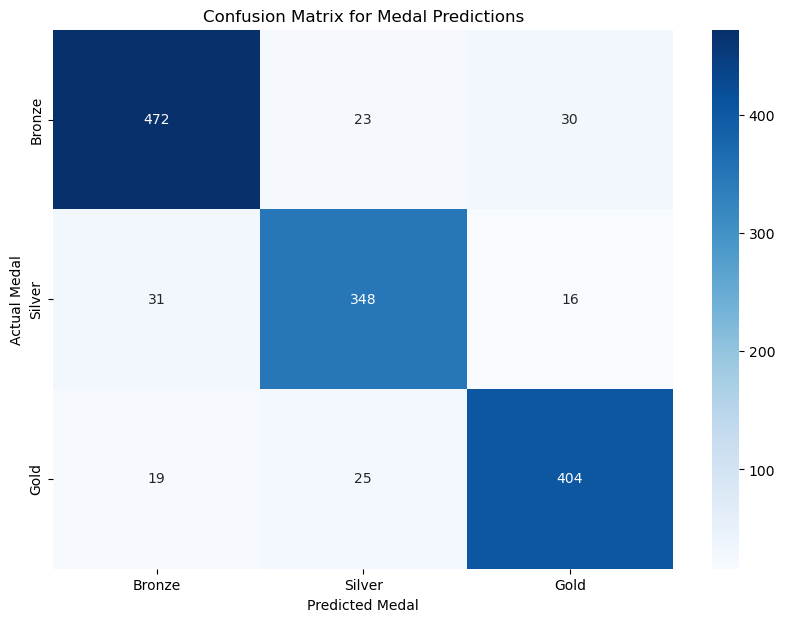

In [287]:

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bronze', 'Silver', 'Gold'], yticklabels=['Bronze', 'Silver', 'Gold'])
plt.xlabel('Predicted Medal')
plt.ylabel('Actual Medal')
plt.title('Confusion Matrix for Medal Predictions')
plt.show()


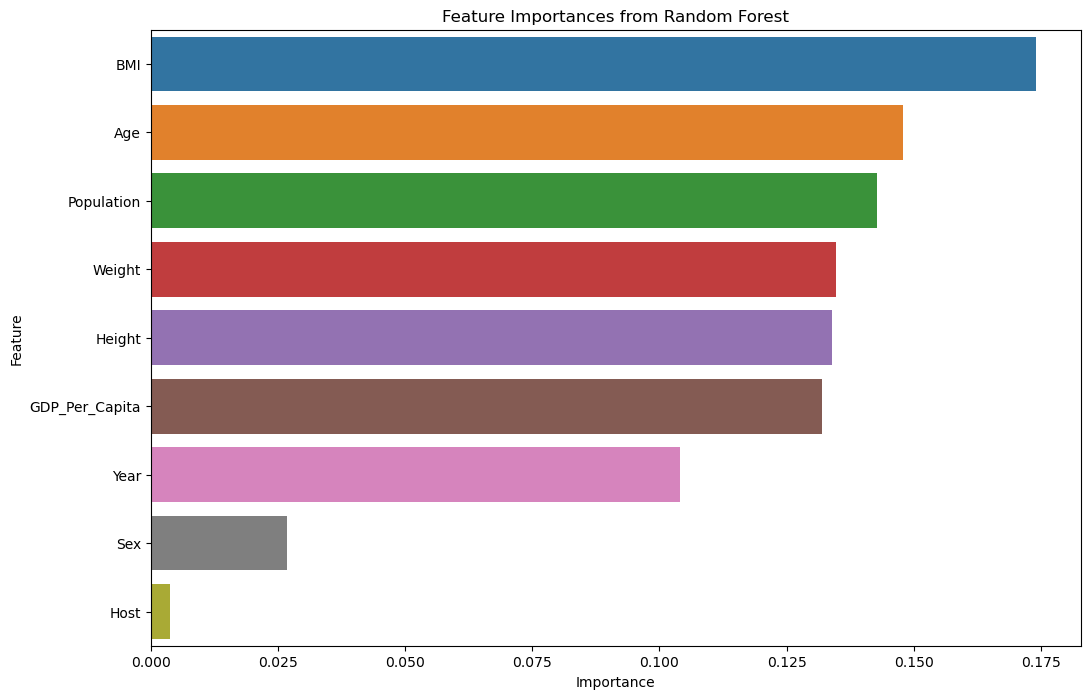

In [288]:
feature_importances = rf_clf.feature_importances_

# Map feature importances to their corresponding feature names
feature_names = feat_df.drop(columns=['ID', 'Medal']).columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the dataframe by importance for better visualization
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### XGBoost Model

In [289]:
# Train XGBoost Classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)
xgb_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_clf.predict(X)


In [290]:
y_pred_proba_xgb = xgb_clf.predict_proba(X)

# Map the encoded labels to the actual medal names
medal_map = {0: 'Bronze', 1: 'Silver', 2: 'Gold'}

# Get the class probabilities for each class
y_pred_proba_df_xgb = pd.DataFrame(y_pred_proba_xgb, columns=[medal_map[i] for i in range(3)])

In [291]:
xgb_preds = pd.concat([y_pred_proba_df_xgb, feat_df], axis=1)

# join with df to join 'Event', 'Name', 'Team', 'Event', 'Sport'
xgb_preds = pd.merge(xgb_preds, df[['ID', 'Event', 'Name', 'Team', 'Sport']], on='ID', how='left')
xgb_preds = xgb_preds.drop_duplicates(subset=['ID'])

In [292]:
top_probable_winners = xgb_preds.groupby('Event').apply(get_top_probable_winners)
top_probable_winners = top_probable_winners.reset_index(drop=True)
top_probable_winners

,Bronze,Silver,Gold,ID,Sex,Age,Height,Weight,Year,Medal,BMI,Host,Population,GDP_Per_Capita,Event,Name,Team,Sport
0,0.354623,0.226707,0.418670,128031,1,30.0,192.0,100.0,2006,2,27.126736,0,8.268641e+06,40635.281816,Alpine Skiing Men's Combined,Michael Walchhofer,Austria,Alpine Skiing
1,0.362911,0.307353,0.329736,31236,1,28.0,180.0,85.0,1998,2,26.234568,0,7.976789e+06,27361.875111,Alpine Skiing Men's Combined,Stephan Eberharter,Austria,Alpine Skiing
2,0.455556,0.245263,0.299181,86344,1,22.0,185.0,90.0,1994,0,26.296567,0,4.336613e+06,29315.841907,Alpine Skiing Men's Combined,Harald Christian Strand Nilsen,Norway,Alpine Skiing
3,0.220735,0.207530,0.571735,83136,1,26.0,184.0,84.0,1984,2,24.810964,0,3.139700e+05,2242.015817,Alpine Skiing Men's Downhill,Peter Mller,Switzerland,Alpine Skiing
4,0.146600,0.772618,0.080782,50781,1,32.0,183.0,90.0,2014,0,26.874496,0,3.554456e+07,50633.208822,Alpine Skiing Men's Downhill,Jan Hudec,Canada,Alpine Skiing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1372,0.268691,0.392331,0.338977,133130,0,21.0,157.0,55.0,2004,1,22.313278,0,1.277610e+08,37688.722336,"Wrestling Women's Lightweight, Freestyle",Saori Yoshida,Japan,Wrestling
1373,0.554477,0.216149,0.229374,41353,0,30.0,158.0,55.0,2004,0,22.031726,0,6.270490e+07,33741.265147,"Wrestling Women's Lightweight, Freestyle",Anna Gomis,France,Wrestling
1374,0.182787,0.371780,0.445433,54909,0,24.0,170.0,63.0,2012,2,21.799308,0,1.350695e+09,6337.883323,"Wrestling Women's Middleweight, Freestyle",Jing Ruixue,China,Wrestling
1375,0.239631,0.430497,0.329871,77851,0,23.0,167.0,62.0,2004,2,22.230987,0,2.928053e+08,41921.809762,"Wrestling Women's Middleweight, Freestyle",Sara McMann,United States,Wrestling


In [293]:
# Map actual medals to numeric values for comparison
medal_map = {'Bronze': 0, 'Silver': 1, 'Gold': 2}

In [294]:
# Determine predicted medals by finding the class with the highest probability
xgb_preds['Predicted_Medal'] = xgb_preds[['Bronze', 'Silver', 'Gold']].idxmax(axis=1)

# Map the predicted and actual medals to numeric values
xgb_preds['Predicted_Medal'] = xgb_preds['Predicted_Medal'].map(medal_map)
xgb_preds['Actual_Medal'] = xgb_preds['Medal']

In [295]:
xgb_preds['Actual_Medal'].value_counts()

Actual_Medal
0    7044
2    6484
1    5705
Name: count, dtype: int64

In [296]:
xgb_preds['Predicted_Medal'].value_counts()

Predicted_Medal
0    7204
2    6131
1    5898
Name: count, dtype: int64

In [297]:
# Calculate accuracy
accuracy = accuracy_score(xgb_preds['Actual_Medal'], xgb_preds['Predicted_Medal'])
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6715


In [298]:
# Calculate confusion matrix and classification report for detailed evaluation
conf_matrix = confusion_matrix(xgb_preds['Actual_Medal'], xgb_preds['Predicted_Medal'])
class_report = classification_report(xgb_preds['Actual_Medal'], xgb_preds['Predicted_Medal'], target_names=['Bronze', 'Silver', 'Gold'])

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[4910 1055 1079]
 [1094 3782  829]
 [1200 1061 4223]]

Classification Report:
              precision    recall  f1-score   support

      Bronze       0.68      0.70      0.69      7044
      Silver       0.64      0.66      0.65      5705
        Gold       0.69      0.65      0.67      6484

    accuracy                           0.67     19233
   macro avg       0.67      0.67      0.67     19233
weighted avg       0.67      0.67      0.67     19233



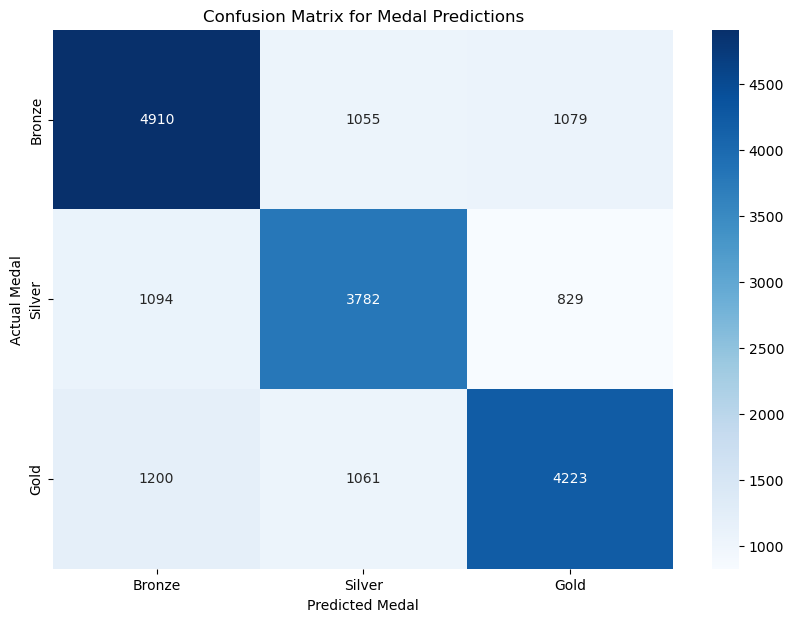

In [299]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bronze', 'Silver', 'Gold'], yticklabels=['Bronze', 'Silver', 'Gold'])
plt.xlabel('Predicted Medal')
plt.ylabel('Actual Medal')
plt.title('Confusion Matrix for Medal Predictions')
plt.show()